# Decision Trees, Random Forests, Boosting

Importation du dataset "Iris" (Fisher ... long ago), on garde les deux premieres caractéristiques de la data pour simplifier la visualization. Plot grace à une fonction de utils modified. 


In [37]:
import sklearn,sklearn.datasets
import numpy,utils
import sklearn.tree

%matplotlib inline

iris = sklearn.datasets.load_iris() # info dataset : https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset

# Definition des data points X et leurs targets T
X,T = iris.data[:,:2],iris.target
# X ne prend en compte que les deux premieres caractéristiques : toutes les lignes et les colonnes 0 et 1 : simplification de la visualization

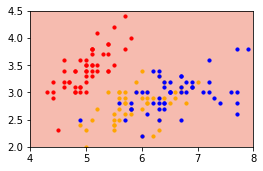

In [38]:
utils.plot_iris(X,T,lambda X: numpy.dot(X,[0,0]))
# Function "plot.iris" from the modified utils : takes as input a classification function mappaing with two input features, then plit the decision function (See exercice)

## Decision Trees

In [39]:
 classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5) 
# Classifier = classif tree classifier form sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# fonction utils.split() pour assigner 50% du dataset pour le training et 50% pour le testing
(Xtrain,Ttrain),(Xtest,Ttest) = utils.split(X,T)

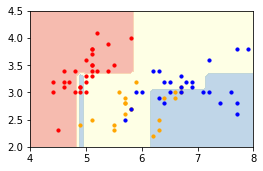

In [40]:
classifier.fit(Xtrain,Ttrain)
utils.plot_iris(Xtest,Ttest,classifier.predict)

Here, the classifier does a reasonable job at classifying the data, although the decision boundaries are a bit too rectangular, and somewhat unnatural.

## Random Forest Classifier addition : 

The random forest method should be close to bagging, with sample drawing with replacement. 
We would like to now compare the decision boundary of the decision tree with the one obtained with a random forest classifier. We consider a random forest composed of 100 trees. Each tree is trained on 50% subset of the training set. (Hint: The function `utils.split` can be called with seeds from 0 to 100 in order to build these random subsets.) The prediction function should implement a majority voting between each tree in the forest. Voting ties do not need to be handled in a particular way.

 * **Implement the `fit` and `predict` functions of the random forest classifier below**

In [ ]:
# help(utils) pour trouver l'astuce du seed : random sampling 


class RandomForestClassifier:
    
    def __init__(self):
        self.trees = [sklearn.tree.DecisionTreeClassifier(max_depth=5) for _ in range(100)]
    
    def fit(self,X,y):
        #Rappel : premier déclaré pour l'enumerate apegal compter index
        for seed, tree in enumerate(self.trees):
            (X_train,T_train),(X_test,T_test) = utils.split(X,y,seed)
            tree.fit(X_train,T_train)
            
    def predict(self,X):
        predictions = numpy.zeros((len(X),len(self.trees)))
        for i,tree in enumerate(self.trees):
            # Slicing sur predictions pour attribuer à chaque
            predictions[:,i] = tree.predict(X).astype(int)
        result = numpy.zeros(len(X))
        for i,x in enumerate(X):
            result[i] = numpy.bincount(predictions[i,:].astype(int)).argmax()
            # numpy.bincounts  :  Count number of occurrences of each value in array of non-negative ints
            # argmax() : max count apegal majority vote
        return result

The code below runs the random forest classifier on the same dataset as before.

In [ ]:
cl = RandomForestClassifier()

(Xtrain,Ttrain),(Xtest,Ttest) = utils.split(X,T)
cl.fit(Xtrain,Ttrain)
utils.plot_iris(Xtest,Ttest,cl.predict)

Unlike the decision boundary obtained by a single decision tree, the random forest tends to produce more curved and natural-looking decision functions.

## Quantitative Experiments

We now focus on understanding more quantitatively the effect on the model accuracy of choosing different models and their parameters. For this, we switch to the regression case, and consider two different datasets also available in `scikit-learn`, the boston dataset, and the diabetes dataset.

In [ ]:
boston   = sklearn.datasets.load_boston()
diabetes = sklearn.datasets.load_diabetes()

The file `utils.py` provides a method `benchmark`, that tests the performance of a model on 100 different train/test splits, and returns the average training and test performance scores. For regression task, the performance score is given by the R2 coefficient of determination (see here https://en.wikipedia.org/wiki/Coefficient_of_determination). A score of "1" is optimal. A score of "0" is essentially random guessing.

In [ ]:
regressor = sklearn.tree.DecisionTreeRegressor(max_depth=5)
strain,stest = utils.benchmark(regressor,boston)
print('training: %.3f | test score: %.3f'%(strain,stest))

In the example above, the test data is predicted fairly well with a coefficient determination above 0.7. Furthermore, we can investigate the effect of depth on the decision tree:

In [ ]:
for d in range(1,10):
    regressor = sklearn.tree.DecisionTreeRegressor(max_depth=d)
    strain,stest = utils.benchmark(regressor,boston)
    print('depth: %d | training score: %.3f | test score: %.3f'%
                                                 (d,strain,stest))

Although the training error keeps increasing, the test error saturates once a depth of 5 has been reached. The same experiment can be performed on the diabetes dataset:

In [ ]:
for d in range(1,10):
    regressor = sklearn.tree.DecisionTreeRegressor(max_depth=d)
    strain,stest = utils.benchmark(regressor,diabetes)
    print('depth: %d | training score: %.3f | test score: %.3f'%
                                                  (d,strain,stest))
    
#Test score is what interests us the most : we need to be able to get goods results on the data left

Here, the best depth is just 2, and the model quality seriously degrades as we continue growing the tree. **This is the result of overfitting**

i.e. as we make the model closer to the data (bias reduction), we are also become highly sensitive to noise in the data and in the sampling process (variance increase).

Very often happens in econometrics bc of too many regressors, over-identificaito of the model, mechanically high R2 but also high variance (some explanation part of the model is alternatively included in defferent regressors depending on the obersations !)

## Implementing a Random Forest Regressor : 

**reducing variance by averaging a large number of models : random forests**

**Here : random forest regressor**  Like for the random forest classifier, each tree is grown on a random subset of the training set containing only half of the examples. As in the first exercise, the function `utils.split` can be used to generate these subsets. Because we are now implementing a regression model, we replace the majority voting by a simple averaging of the prediction of the different trees. The implementation below inherits some useful methods from the class `sklearn.base.RegressorMixin` in particular the function `score` measuring the coefficient of determination, which therefore does not need to be reimplemented.

 * **Implement the `fit` and `predict` functions of the random forest regressor below.**

In [ ]:
class RandomForestRegressor(sklearn.base.RegressorMixin):
    
    def __init__(self,max_depth=None,nb_trees=10):
        self.trees = [sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
        for _ in range(nb_trees)]

    def fit(self,X,y):
        for seed, tree in enumerate(self.trees):
            (X_train,T_train),(X_test,T_test) = utils.split(X,y,seed)
            tree.fit(X_train,T_train)

    def predict(self,X):
        predictions = numpy.zeros((len(X), len(self.trees)))
        for i,tree in enumerate(self.trees):
            predictions[:,i] = tree.predict(X)
            result = numpy.mean(predictions, axis=1)
        return result


To check whether the random forest brings an improvement over the simple decision tree algorithm, we select the best decision tree obtained so far (`d=7`), and compare its accuracy to our random forest regressor. Here, because of the averaging effect of the random forest, we can afford higher depths, for example, `d=9`. The code below test the performance of random forests of increasingly many trees.

In [ ]:
# Benchmark for baseline decision tree model
regressor = sklearn.tree.DecisionTreeRegressor(max_depth=7)
strain,stest = utils.benchmark(regressor,boston)
print("decision tree (optimal depth): | train: %.3f | test: %.3f"%
      (strain,stest))

# Benchmark for the random forest model with a growing number of trees
for nb_trees in [1,2,4,8,16,32]:
    regressor = RandomForestRegressor(max_depth=9,nb_trees=nb_trees)
    strain,stest = utils.benchmark(regressor,boston)
    print("random forest with %2d tree(s): | train: %.3f | test: %.3f"%
          (nb_trees,strain,stest))

As it can be observed from the results above, the test scores of a random forest are much better. Due to their high performance, random forests are often used in practical applications.

## Implementing a Simple Boosted Tree Regressor

Another extension to the simple decision tree regressor, is the boosted tree regressor. Here, instead of averaging a large number of trees grown from randomly sampled data, the extra trees serve to predict what the previous trees failed to predict, i.e. the residual error. Technically, the variant of the boosted tree regressor we consider here is defined as follows:

Let $F_k(x) = f_1(x) + f_2(x) + \dots + f_k(x)$ be the prediction of a boosted regressor with $k$ trees, and some ground truth function $y(x)$, the next boosted regressor adds an additional decision tree $f_{k+1}(x)$ trained on the residual function $r(x) = y(x) - F_k(x)$, and the resulting boosted classifier becomes $F_{k+1}(x) = f_1(x) + f_2(x) + \dots + f_k(x) + f_{k+1}(x)$.

In [ ]:
class SimpleBoostedTreeRegressor(sklearn.base.RegressorMixin):
    
    def __init__(self,max_depth=None,nb_trees=10):
        self.trees = [sklearn.tree.DecisionTreeRegressor(max_depth=max_depth) for _ in range(nb_trees)]

        
    def fit(self,X,y):
        self.used_trees = 0
        for i, tree in enumerate(self.trees):
            if (i==0):
                tree.fit(X,y)
            else:
                Fk = self.predict(X)
                tree.fit(X,y-Fk)
                
                
            self.used_trees += 1

            
    def predict(self,X):
        result = numpy.zeros(len(X))
        for tree in self.trees[:self.used_trees]:
            result += tree.predict(X)
        return result

The code below compares the boosted tree regressor to the simple decision tree on the diabetes dataset. Here, we use for the decision tree a depth 2, that yields maximum accuracy on this dataset. As boosting allows to grows complex decisions from weak regressors, we set maximum tree depth to 1.

In [ ]:
# Benchmark for baseline decision tree model
regressor = sklearn.tree.DecisionTreeRegressor(max_depth=2)
strain,stest = utils.benchmark(regressor,diabetes)
print("decision tree (optimal depth): | train: %.3f | test: %.3f"%
      (strain,stest))

# Benchmark for the boosted tree regressor model with a growing number of trees
for nb_trees in [1,2,4,8,16,32,64]:
    regressor = SimpleBoostedTreeRegressor(max_depth=1,nb_trees=nb_trees)
    strain,stest = utils.benchmark(regressor,diabetes)
    print("boosting with %2d trees(s):     | train: %.3f | test: %.3f"%
          (nb_trees,strain,stest))

Like for the random forests, the boosted tree regressor also brings an improvement compared to the simple decision tree. Note that adding too many trees may still cause overfitting (here, a good number of trees is 16). If we would like to include more trees, an even weaker base model should be used if available.

### Dependency of regression performance on model complexity

Finally, we can study how the performance of each model depends on the tree depth. In this last experiment, the number of trees in the random forest and boosted model are kept fixed, and the tree depth is varied. Experiments are performed for all datasets and algorithms and results are shown as plots.

In [1]:
depths     = [1,2,3,4,5,6,7,8]
datasets   = [boston,diabetes]
names      = ['boston','diabetes']
algorithms = [sklearn.tree.DecisionTreeRegressor,
              RandomForestRegressor,
              SimpleBoostedTreeRegressor]

from matplotlib import pyplot as plt

for dataset,name in zip(datasets,names):
    plt.figure()
    plt.title(name)
    
    for algorithm in algorithms:
        
        acc = [utils.benchmark(algorithm(max_depth=i),dataset)[1]
               for i in depths]
        
        plt.plot(depths,acc,'o-',label=algorithm.__name__)

    plt.grid(True)
    plt.xlabel('tree depth')
    plt.ylabel('coefficient of determination')
    plt.legend(loc='lower right')
    plt.show()

NameError: name 'boston' is not defined

It can be observed that the random forest method tends to prefer deep trees. Indeed, the variance increase caused by deeper trees is countered by the averaging mechanism. Conversely, the boosting algorithm prefers small trees as it is able to build complex models even from simple weak regressors.